In [1]:
import math
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

In [2]:
""" LATTICE-BASED DBSCAN """
class DBSCAN:
    def __init__(self, df, config):
        self.df = df
        self.numRow = config['NumRow']
        self.numCol = config['NumCol']
        self.min_x = config['Min_x']
        self.min_y = config['Min_y']
        self.increment = config['Increment']
        self.vesselType = config['VesselType']
        self.minSC = config['MinSC']
        self.minNeigb = config['MinNeigb']
        
        self.lattice = self.initialize_lattice()
    
    def get_index(self, pos_x, pos_y):
        index_x = math.ceil((pos_x - self.min_x) / self.increment) - 1
        index_y = self.numRow - math.ceil((pos_y - self.min_y) / self.increment)
        return index_x, index_y
    
    def initialize_lattice(self):
        lattice = [[None] * self.numCol for _ in range(self.numRow)]
        for i in range(self.numRow):
            for j in range(self.numCol):
                lattice[self.numRow-1-i][j] = {'x': self.min_x + j*self.increment,
                                               'y': self.min_y + i*self.increment,
                                               'code': None,
                                               'sampleCount': 0,
                                               'type/vslid': self.vesselType,
                                               'label': None,
                                               'clusterId': None}
        for idx, row in self.df.iterrows():
            index_x, index_y = self.get_index(row['x'], row['y'])
            if row['x'] == self.min_x:
                index_x = 0
            if row['y'] == self.min_y:
                index_y = 0
            lattice[index_y][index_x]['sampleCount'] += 1
        return lattice
    
    def get_neighbors(self, col, row):
        positions = [(col-1, row), (col-1, row-1), 
                     (col, row-1), (col+1, row-1), 
                     (col+1, row), (col+1, row+1), 
                     (col, row+1), (col-1, row+1)]
        ret = []
        numNeigb = 0
        for pos in positions:
            if (pos[0] < 0 or pos[0] >= len(self.lattice[0]) or
                    pos[1] < 0 or pos[1] >= len(self.lattice)):
                continue
            if self.lattice[pos[1]][pos[0]] == 'noise':
                continue
            else:
                if self.lattice[pos[1]][pos[0]]['sampleCount'] <= self.minSC:
                    self.lattice[pos[1]][pos[0]]['label'] = 'noise'
                else:
                    if not self.lattice[pos[1]][pos[0]]['label']:
                        ret.append(pos)
                    numNeigb += 1
        return ret, numNeigb
    
    def process_node(self, node, curr_cluster):
        q = deque()
        if self.lattice[node[1]][node[0]]['sampleCount'] <= self.minSC:
            self.lattice[node[1]][node[0]]['label'] = 'noise'
            return False
        neighbors, numNeigb = self.get_neighbors(node[0], node[1])
        
        if numNeigb >= self.minNeigb:
            self.lattice[node[1]][node[0]]['clusterId'] = curr_cluster
            self.lattice[node[1]][node[0]]['label'] = 'processed'
            for neighbor in neighbors:
                q.append(neighbor)
                self.lattice[neighbor[1]][neighbor[0]]['label'] = 'unprocessed'
        else:
            return False
        
        while q:
            cur = q.popleft()
            self.lattice[cur[1]][cur[0]]['clusterId'] = curr_cluster
            self.lattice[cur[1]][cur[0]]['label'] = 'processed'
            neighbors, numNeigb = self.get_neighbors(cur[0], cur[1])
            
            if numNeigb >= self.minNeigb:
                for neighbor in neighbors:
                    q.append(neighbor)
                    self.lattice[neighbor[1]][neighbor[0]]['label'] = 'unprocessed'
        return True
    
    def scan(self):
        curr_cluster = 1
        for i in range(self.numRow):
            for j in range(self.numCol):
                if self.lattice[i][j]['label'] == 'noise' or self.lattice[i][j]['label'] == 'processed':
                    continue
                else:
                    node = (j,i)
                    foundCluster = self.process_node(node, curr_cluster)
                    if foundCluster:
                        curr_cluster += 1
                        
                        
""" KDE BASED VESSEL MOTION BEHAVIOR """
from sklearn.neighbors import KernelDensity
# from sklearn.model_selection import GridSearchCV

class kde_motion:
    def __init__(self, df, config):
        self.df = df
        self.time_windows = config['TimeWindows']
        self.store_param = config['StoreParam']
        self.vessels = self.get_vessels()
        self.vessels_pdfs = {}
        
    def get_vessels(self):
        return self.df['MMSI'].unique()
    
    def get_vessel_df(self, selected_vessel):
        new_df = self.df[self.df.MMSI == selected_vessel]
        new_df = new_df.reset_index()
        return new_df
    
    def get_traveling_dist(self, vessel_x, vessel_y, vessel_time, time_window):
        num_segments = (int(vessel_time.max()) - int(vessel_time.min())) // time_window
        traveling_dist = [None] * num_segments
        traveling_variation = [None] * (num_segments - 1)
        
        j = 1
        prev_x, prev_y = vessel_x[0], vessel_y[0]
        total_traveling_dist = 0
        for i in range(num_segments):
            time = (i+1) * time_window + vessel_time[0]
            while time > vessel_time[j]:
                j += 1
            ratio = (time - vessel_time[j-1]) / (vessel_time[j] - vessel_time[j-1])
            pos_x = (vessel_x[j] - vessel_x[j-1]) * ratio + prev_x
            pos_y = (vessel_y[j] - vessel_y[j-1]) * ratio + prev_y
            distance = ((pos_x - prev_x) ** 2 + (pos_y - prev_y) ** 2) ** 0.5
            total_traveling_dist += distance
            traveling_dist[i] = total_traveling_dist
            prev_x, prev_y = pos_x, pos_y
            if i>0:
                traveling_variation[i-1] = traveling_dist[i] - traveling_dist[i-1]

        return np.array(traveling_dist), np.array(traveling_variation)
    
    def conduct_kde_single(self, time_window, selected_vessel):
        new_df = self.get_vessel_df(selected_vessel)
        traveling_dist, traveling_variation = self.get_traveling_dist(new_df['x'], new_df['y'], new_df['time'], time_window)
        
#         grid = GridSearchCV(KernelDensity(kernel='gaussian'),
#                            {'bandwidth': np.linspace(0.1, 1.0, 30)},
#                            cv=20)
#         grid.fit(traveling_variation[:, None])
#         x_grid = np.linspace(self.store_param[0], self.store_param[1], self.store_param[2])
#         kde = grid.best_estimator_
#         pdf = np.exp(kde.score_samples(x_grid[:, None]))

        kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(traveling_variation[:, None])
        x_grid = np.linspace(self.store_param[0], self.store_param[1], self.store_param[2])
        pdf = np.exp(kde.score_samples(x_grid[:, None]))
        
        return pdf
    
    def get_pdfs(self):
        for vessel in self.vessels:  # HERE WE ONLY USE 5 VESSELS TO CALCULATE
            vessel_pdf_list = {}
            for time_window in self.time_windows:
                vessel_pdf_list[time_window] = (self.conduct_kde_single(time_window, vessel))
            self.vessels_pdfs[str(vessel)] = vessel_pdf_list
        return self.vessels_pdfs
    
    def combine_pdfs(self):
        combined_pdfs = {}
        for i in range(len(self.time_windows)):
            comb_pdf = np.zeros(self.store_param[2])
            for key in self.vessels_pdfs.keys():
                comb_pdf += self.vessels_pdfs[key][self.time_windows[i]]
            comb_pdf /= len(self.vessels_pdfs)
            combined_pdfs[self.time_windows[i]] = comb_pdf
        return combined_pdfs

In [3]:
df = pd.read_csv('./ProcessedData_engined_wutm.csv')
df = df[['MMSI', 'x', 'y', 'time', 'VesselType', 'Heading']]
print(df.shape)
df.head(2)

(13457486, 6)


,MMSI,x,y,time,VesselType,Heading
0,366856070,4.076630e+06,5.117847e+06,0.0,31.0,NaN
1,366862820,4.081162e+06,5.110275e+06,0.0,31.0,NaN


In [8]:
# Set config file
FilterMap = [4090000,4070000,5130000,5110000]
TimeWindows = [i for i in range(1, 61)]
config = {'ScaleDown': 1,
          'VesselType': None,
          'FilterMap': FilterMap,
          'NumCol': 1000,
          'NumRow': 1000,
          'Increment': 20,
          'Min_x': FilterMap[1],
          'Min_y': FilterMap[3],
          'MinSC': 2,
          'MinNeigb': 1,
          'StoreParam': [-4, 4, 101],
          'TimeWindows': TimeWindows,
          'Threshold': None,
          }

In [9]:
import time

start = time.time()
DBSCAN_object = DBSCAN(df, config)
DBSCAN_object.scan()
lattice = DBSCAN_object.lattice
end = time.time()
print('Runtime for DBSCAN is: {}'.format(end-start))

Runtime for DBSCAN is: 1398.3026189804077


In [10]:
# start = time.time()
# KDE_object = kde_motion(df, config)
# vessel_pdfs = KDE_object.get_pdfs()
# end = time.time()
# print('Runtime for KDE is: {}'.format(end-start))

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29}


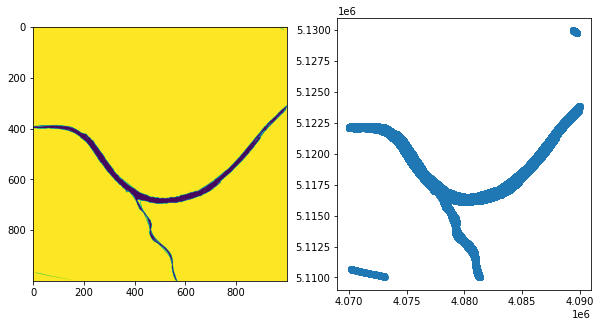

In [11]:
visualize_arr = np.empty([config['NumRow'], config['NumCol']])
clusters = []
for i in range(config['NumRow']):
    for j in range(config['NumCol']):
        if lattice[i][j]['clusterId'] == None:
            visualize_arr[i][j] = 50
        else:
            visualize_arr[i][j] = int(lattice[i][j]['clusterId'])
            clusters.append(int(lattice[i][j]['clusterId']))
print(set(clusters))
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].imshow(visualize_arr)
axes[1].scatter(df['x'], df['y'])

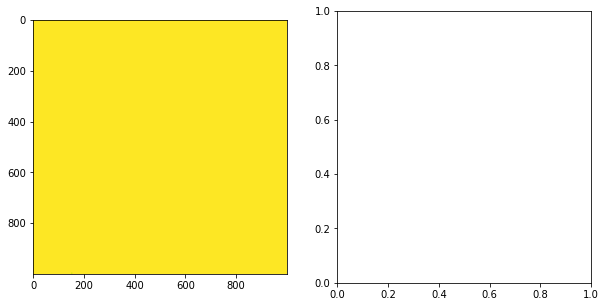

In [41]:
visualize_arr = np.empty([config['NumRow'], config['NumCol']])
clusters = []
for i in range(config['NumRow']):
    for j in range(config['NumCol']):
        if lattice[i][j]['clusterId'] == 29:
            visualize_arr[i][j] = 1
        else:
            visualize_arr[i][j] = 50
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].imshow(visualize_arr)
# axes[1].scatter(df['x'], df['y'])

In [ ]:
x_grid = np.linspace(config['StoreParam'][0], config['StoreParam'][1], config['StoreParam'][2])
fig, ax = plt.subplots()
ax.plot(x_grid, vessels_pdfs['211578000.0'][60], linewidth=3, alpha=0.5)
ax.legend(loc='upper left')
ax.set_xlim(-4, 4)